This project presents an unsupervised approach to anomaly detection in time-series data using deep learning techniques. By leveraging a stacked Long Short-Term Memory (LSTM) network trained on synthetically generated sensor signals, the system learns to model normal temporal patterns. Deviations from expected behavior are identified by evaluating prediction errors, which are then analyzed using the DBSCAN clustering algorithm to isolate anomalous regions. The method requires no labeled data, making it ideal for real-world scenarios where anomalies are rare or undefined in advance. This hybrid architecture enables robust detection of subtle and abrupt anomalies in streaming sensor data.

## Import Libraries

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation



In [2]:

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
# Hyperparameters
sequence_length = 100
augmentation_factor = 10
epochs = 5
batch_size = 64

### Data Generation

 Generate a synthetic wave signal and inject an artificial anomaly pattern into it.

In [4]:
def generate_waveform():
    t = np.arange(0.0, 10.0, 0.01)
    base_wave = np.sin(4 * np.pi * t)
    noise = np.random.normal(0, 0.1, len(t))
    wave = base_wave + noise + np.sin(2 * np.pi * t)

    # Inject a short anomaly wave
    anomaly_wave = np.sin(10 * np.pi * np.arange(0.0, 0.5, 0.01))
    insert_at = int(0.8 * len(t))
    wave[insert_at:insert_at+50] += anomaly_wave
    return wave

### Data Preprocessing


Normalize and prepare the data into sequences for supervised training.

In [5]:

def normalize(data):
    return (data - data.mean()) / data.std()


In [6]:

def prepare_data(data, start_idx, end_idx):
    result = [data[i: i + sequence_length] for i in range(start_idx, end_idx - sequence_length)]
    result = np.array(result)
    norm_result = normalize(result)
    return norm_result

In [7]:

def augment(X, y):
    augmented_X, augmented_y = [], []
    for i in range(len(X)):
        repeat_count = np.random.randint(1, augmentation_factor)
        for _ in range(repeat_count):
            augmented_X.append(X[i])
            augmented_y.append(y[i])
    return np.array(augmented_X), np.array(augmented_y)


In [8]:
def split_data(data):
    train_data = prepare_data(data, 0, 700)
    test_data = prepare_data(data, 500, 1000)

    X_train = train_data[:, :-1]
    y_train = train_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    X_train, y_train = augment(X_train, y_train)

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, y_train, X_test, y_test

### Model Architecture

In [9]:
# Create a stacked LSTM model for sequence prediction.

def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(sequence_length - 1, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='rmsprop', loss='mse')
    return model


## Training and Evaluation

C:\Users\JOYEETA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model...
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 695ms/step - loss: 0.3638 - val_loss: 0.1780
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 734ms/step - loss: 0.0759 - val_loss: 0.1149
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 742ms/step - loss: 0.0681 - val_loss: 0.0290
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 735ms/step - loss: 0.0464 - val_loss: 0.0247
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 749ms/step - loss: 0.0379 - val_loss: 0.0273
Predicting...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step


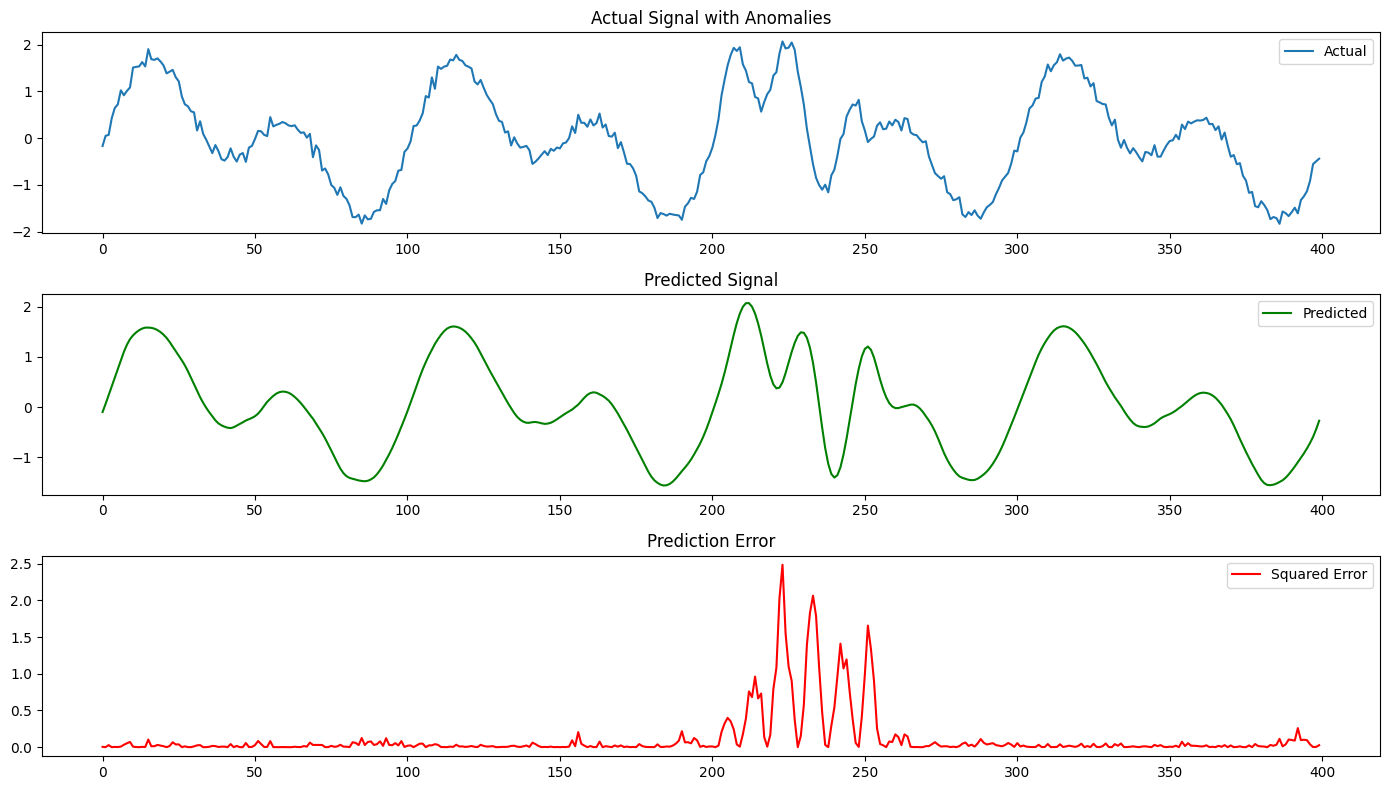

Training and evaluation completed in 218.79 seconds.


In [10]:

  wave = generate_waveform()
  X_train, y_train, X_test, y_test = split_data(wave)

  model = build_lstm_model()
  start_time = time.time()

  print("Training model...")
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

  print("Predicting...")
  predictions = model.predict(X_test).flatten()

  mse = (predictions - y_test) ** 2

  # Visualization
  plt.figure(figsize=(14, 8))
  plt.subplot(311)
  plt.plot(y_test, label="Actual")
  plt.title("Actual Signal with Anomalies")
  plt.legend()

  plt.subplot(312)
  plt.plot(predictions, label="Predicted", color='green')
  plt.title("Predicted Signal")
  plt.legend()

  plt.subplot(313)
  plt.plot(mse, label="Squared Error", color='red')
  plt.title("Prediction Error")
  plt.legend()

  plt.tight_layout()
  plt.show()

  print(f"Training and evaluation completed in {time.time() - start_time:.2f} seconds.")
  # return predictions


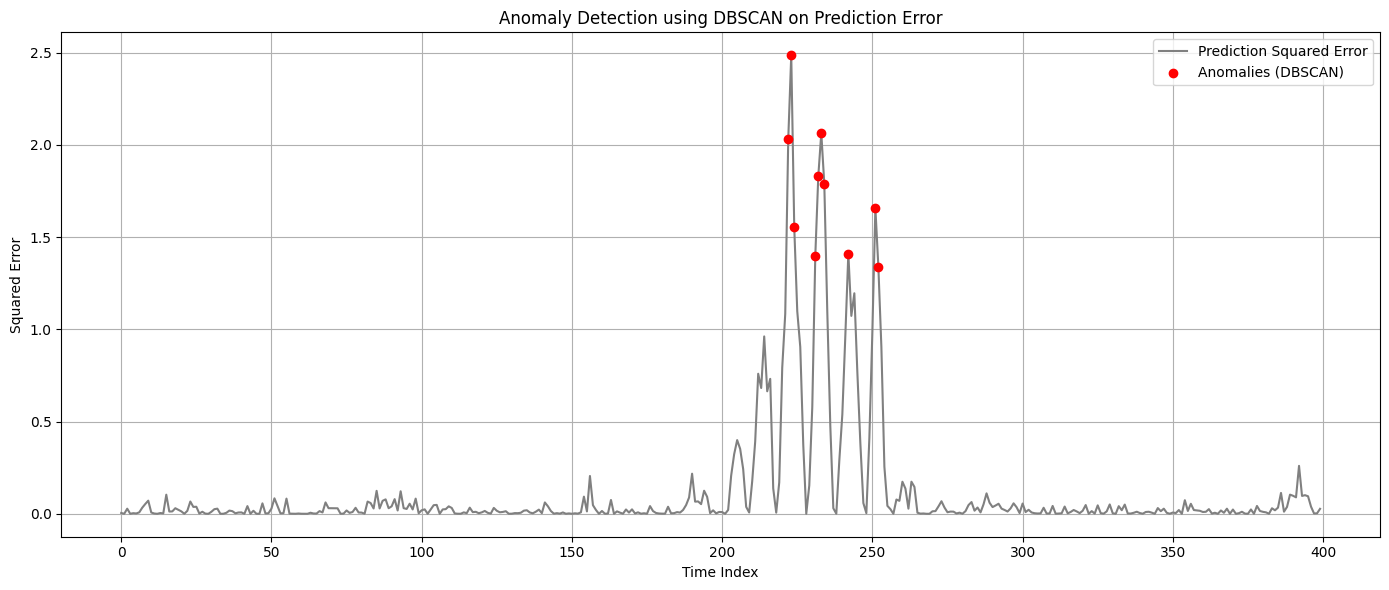

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Compute squared error
mse = (predictions - y_test) ** 2

# DBSCAN requires 2D input, so we reshape
error_reshaped = mse.reshape(-1, 1)

# Apply DBSCAN clustering
# Adjust `eps` and `min_samples` if needed
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(error_reshaped)

# Extract anomaly points (label = -1)
anomaly_indices = np.where(labels == -1)[0]
anomaly_scores = mse[anomaly_indices]

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(mse, label="Prediction Squared Error", color="gray")
plt.scatter(anomaly_indices, anomaly_scores, color="red", label="Anomalies (DBSCAN)", zorder=3)
plt.title("Anomaly Detection using DBSCAN on Prediction Error")
plt.xlabel("Time Index")
plt.ylabel("Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
